<a href="https://colab.research.google.com/github/chandagrover/Machine-Learning/blob/master/conditionalvae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install tensorflow==1.12
# !pip install keras==2.2.4

In [5]:
import warnings
import numpy as np
from keras.layers import Input, Dense, Lambda
from keras.layers.merge import concatenate as concat
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
# from scipy.misc import imsave
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [6]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [7]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

n_pixels = np.prod(X_train.shape[1:])
X_train = X_train.reshape((len(X_train), n_pixels))
X_test = X_test.reshape((len(X_test), n_pixels))

In [8]:

y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)

In [9]:

m = 250 # batch size
n_z = 2 # latent space size
encoder_dim1 = 512 # dim of encoder hidden layer
decoder_dim = 512 # dim of decoder hidden layer
decoder_out_dim = 784 # dim of decoder output layer
activ = 'relu'
optim = Adam(lr=0.001)


n_x = X_train.shape[1]
n_y = y_train.shape[1]


n_epoch = 50

In [10]:

X = Input(shape=(n_x,))
label = Input(shape=(n_y,))

In [11]:
inputs = concat([X, label])

In [12]:

encoder_h = Dense(encoder_dim1, activation=activ)(inputs)
mu = Dense(n_z, activation='linear')(encoder_h)
l_sigma = Dense(n_z, activation='linear')(encoder_h)

In [13]:
def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps


# Sampling latent space
z = Lambda(sample_z, output_shape = (n_z, ))([mu, l_sigma])

In [14]:

z = Lambda(sample_z, output_shape = (n_z, ))([mu, l_sigma])

# merge latent space with label
zc = concat([z, label])

In [15]:

decoder_hidden = Dense(decoder_dim, activation=activ)
decoder_out = Dense(decoder_out_dim, activation='sigmoid')
h_p = decoder_hidden(zc)
outputs = decoder_out(h_p)

In [16]:
def vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    kl = 0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=-1)
    return recon + kl

def KL_loss(y_true, y_pred):
	return(0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
	return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [17]:
cvae = Model([X, label], outputs)
encoder = Model([X, label], mu)

d_in = Input(shape=(n_z+n_y,))
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
decoder = Model(d_in, d_out)

In [18]:
cvae.compile(optimizer=optim, loss=vae_loss, metrics = [KL_loss, recon_loss])

In [19]:
cvae_hist = cvae.fit([X_train, y_train], X_train, verbose = 1, batch_size=m, epochs=n_epoch,
							validation_data = ([X_test, y_test], X_test),
							callbacks = [EarlyStopping(patience = 5)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 14s 229us/step - loss: 199.0482 - KL_loss: 9.2111 - recon_loss: 189.8371 - val_loss: 155.4474 - val_KL_loss: 4.5128 - val_recon_loss: 150.9346
Epoch 2/50
60000/60000 [==============================] - 13s 219us/step - loss: 148.8948 - KL_loss: 4.3671 - recon_loss: 144.5278 - val_loss: 144.3432 - val_KL_loss: 4.3262 - val_recon_loss: 140.0170
Epoch 3/50
60000/60000 [==============================] - 13s 219us/step - loss: 142.7117 - KL_loss: 4.2972 - recon_loss: 138.4145 - val_loss: 141.0079 - val_KL_loss: 4.2308 - val_recon_loss: 136.7771
Epoch 4/50
60000/60000 [==============================] - 13s 217us/step - loss: 140.3454 - KL_loss: 4.2891 - recon_loss: 136.0563 - val_loss: 139.4750 - val_KL_loss: 4.1540 - val_recon_loss: 135.3210
Epoch 5/50
60000/60000 [==============================] - 13s 217us/step - loss: 138.9006 - KL_loss: 4.3021 - recon_loss: 134.5986 - val_loss: 138

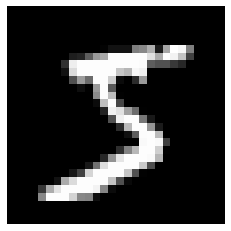

In [20]:
plt.imshow(X_train[0].reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()

In [21]:
encoded_X0 = encoder.predict([X_train[0].reshape((1, 784)), y_train[0].reshape((1, 10))])
print(encoded_X0)

[[-0.35303834 -0.5150741 ]]


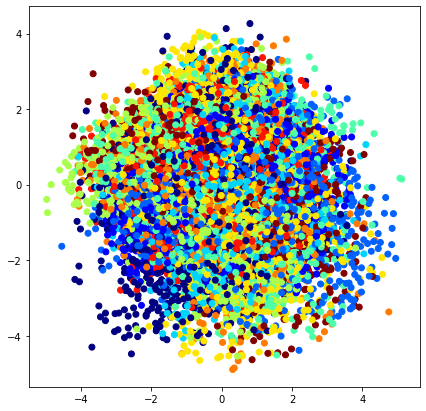

In [22]:

z_train = encoder.predict([X_train, y_train])
encodings= np.asarray(z_train)
encodings = encodings.reshape(X_train.shape[0], n_z)
plt.figure(figsize=(7, 7))
plt.scatter(encodings[:, 0], encodings[:, 1], c=Y_train, cmap=plt.cm.jet)
plt.show()

In [24]:

def construct_numvec(digit, z = None):
    out = np.zeros((1, n_z + n_y))
    out[:, digit + n_z] = 1.
    if z is None:
        return(out)
    else:
        for i in range(len(z)):
            out[:,i] = z[i]
        return(out)
    
sample_3 = construct_numvec(3)
print(sample_3)

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


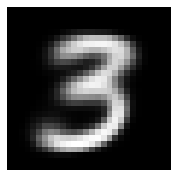

In [25]:

plt.figure(figsize=(3, 3))
plt.imshow(decoder.predict(sample_3).reshape(28,28), cmap = plt.cm.gray), axis('off')
plt.show()

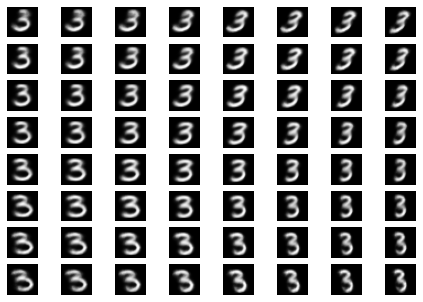

In [26]:
dig = 3
sides = 8
max_z = 1.5

img_it = 0
for i in range(0, sides):
    z1 = (((i / (sides-1)) * max_z)*2) - max_z
    for j in range(0, sides):
        z2 = (((j / (sides-1)) * max_z)*2) - max_z
        z_ = [z1, z2]
        vec = construct_numvec(dig, z_)
        decoded = decoder.predict(vec)
        subplot(sides, sides, 1 + img_it)
        img_it +=1
        plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)
plt.show()

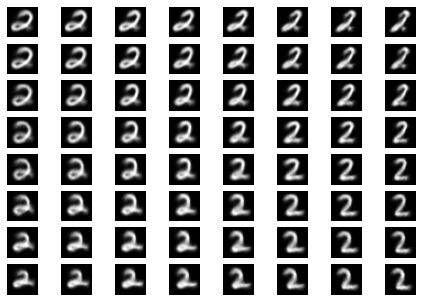

In [27]:

dig = 2
sides = 8
max_z = 1.5

img_it = 0
for i in range(0, sides):
    z1 = (((i / (sides-1)) * max_z)*2) - max_z
    for j in range(0, sides):
        z2 = (((j / (sides-1)) * max_z)*2) - max_z
        z_ = [z1, z2]
        vec = construct_numvec(dig, z_)
        decoded = decoder.predict(vec)
        subplot(sides, sides, 1 + img_it)
        img_it +=1
        plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)
plt.show()